/home/fuukanoo/workspace/jisyu-zemi/.venv/lib/python3.10/site-packages/ot/bregman/_sinkhorn.py:632: RuntimeWarning: divide by zero encountered in divide
  u = 1.0 / nx.dot(Kp, v)
/home/fuukanoo/workspace/jisyu-zemi/.venv/lib/python3.10/site-packages/ot/bregman/_sinkhorn.py:643: UserWarning: Warning: numerical errors at iteration 0
  warnings.warn("Warning: numerical errors at iteration %d" % ii)


Saved results to results/ot_results.npz
Total cost: 0.0000


findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Fo

Plot saved to results/shift_prob.png


findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans CJK JP' not found.


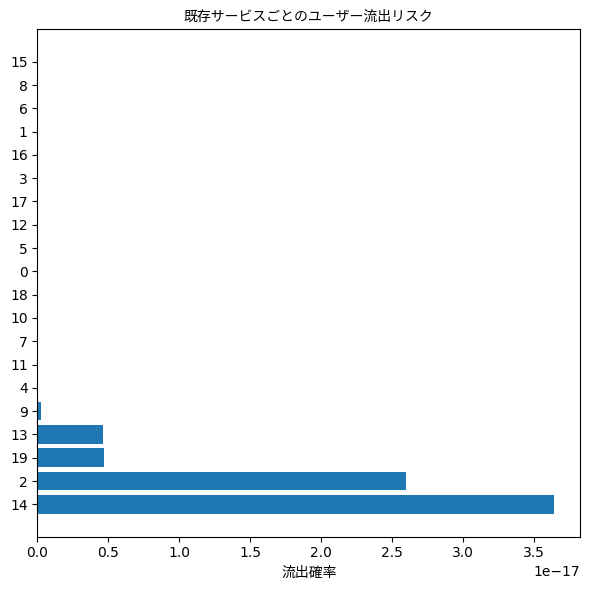

In [10]:
import argparse
import numpy as np
import ot
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import sys
import os
import matplotlib.font_manager as fm

# ── フォント設定 ─────────────────────────────
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams["font.family"] = font_prop.get_name()

# argparseの定義
p = argparse.ArgumentParser(
    description="市場シフト予測：Optimal Transport → 結果を .npz に保存"
)
p.add_argument(
    "--curr",
    type=str,
    required=True,
    help="既存サービス埋め込みファイル (.npy)"
)
p.add_argument(
    "--fut",
    type=str,
    required=True,
    help="未来サービス埋め込みファイル (.npy)"
)
p.add_argument(
    "--out",
    type=str,
    default="results/ot_results.npz",
    help="OT結果を保存するファイルパス (.npz)。デフォルト: %(default)s"
)
p.add_argument(
    "--reg",
    type=float,
    default=5e-2,
    help="Sinkhorn正則化パラメータ ε。デフォルト: %(default)s"
)
p.add_argument(
    "--plot",
    action="store_true",
    help="True の場合、輸送プランのヒートマップをプロットして保存／表示します"
)

# 実際のファイルパスを使用
sys.argv = [
    "script.py",
    "--curr", "embeddings.npy",  # 既存の埋め込みファイル
    "--fut", "emb_new.npy",      # 未来の埋め込みファイル
    "--out", "results/ot_results.npz",
    "--reg", "0.05",
    "--plot"
]

# 以下は同じ
def load_embeddings(path: str) -> np.ndarray:
    return np.load(path)

def compute_cost_matrix(X: np.ndarray, Y: np.ndarray) -> np.ndarray:
    # ユークリッド距離
    return pairwise_distances(X, Y, metric="euclidean")

def compute_ot_sinkhorn(a, b, D, reg=1e-2):
    # Sinkhorn アルゴリズムで正則化付き OT
    T = ot.sinkhorn(a, b, D, reg)
    return T

def main(args):
    # 1. 埋め込みロード
    X_curr = load_embeddings(args.curr)  # (n_curr, d)
    Y_fut  = load_embeddings(args.fut)   # (n_fut , d)

    # 2. 質量設定 (一様分布)
    n, m = X_curr.shape[0], Y_fut.shape[0]
    a = np.ones(n) / n
    b = np.ones(m) / m

    # 3. コスト行列
    D = compute_cost_matrix(X_curr, Y_fut)

    # 4. OT (Sinkhorn)
    T = compute_ot_sinkhorn(a, b, D, reg=args.reg)

    # 5. 結果保存
    np.savez(args.out,
             T=T, D=D, a=a, b=b,
             total_cost=(T * D).sum(),
             shift_prob=T.sum(axis=1))
    print(f"Saved results to {args.out}")
    print(f"Total cost: {(T*D).sum():.4f}")

    # 6. 可視化（簡易版）
    if args.plot:
        plt.figure(figsize=(6,6))
        # 流出確率バー
        shift_prob = T.sum(axis=1)
        idx = np.argsort(shift_prob)[::-1]
        plt.barh(np.arange(len(shift_prob)), shift_prob[idx])
        plt.yticks(np.arange(len(shift_prob)), idx)
        plt.xlabel("流出確率", fontproperties=font_prop)
        plt.title("既存サービスごとのユーザー流出リスク", fontproperties=font_prop)
        plt.tight_layout()
        plt.savefig("results/shift_prob.png")
        print("Plot saved to results/shift_prob.png")

if __name__ == "__main__":
    # 引数の解析
    args = p.parse_args()
    
    # 出力ディレクトリを作成
    out_dir = os.path.dirname(args.out)
    if out_dir and not os.path.exists(out_dir):
        os.makedirs(out_dir)
    
    # メイン処理の実行
    main(args)

In [11]:
import numpy as np

# .npzファイルを読み込む
data = np.load('results/ot_results.npz')

# ファイル内の配列を確認
print(data.files)  # 保存されている配列の名前を表示

# 特定の配列にアクセス
T = data['T']  # 輸送プラン
D = data['D']  # コスト行列
a = data['a']  # ソース分布
b = data['b']  # ターゲット分布
total_cost = data['total_cost']  # 総コスト
shift_prob = data['shift_prob']  # シフト確率

# 配列の形状を確認
print(f"輸送プランの形状: {T.shape}")
print(f"コスト行列の形状: {D.shape}")
print(f"総コスト: {total_cost}")
print(f"シフト確率の形状: {shift_prob.shape}")

['T', 'D', 'a', 'b', 'total_cost', 'shift_prob']
輸送プランの形状: (20, 20)
コスト行列の形状: (20, 20)
総コスト: 1.1619343860550316e-16
シフト確率の形状: (20,)


In [12]:
import numpy as np
import pandas as pd

# 1. .npzファイルの読み込み
ot_results = np.load("results/ot_results.npz")  # または "ot_results.npz" など

# 2. DataFrameへの変換
df_T = pd.DataFrame(ot_results["T"])
df_D = pd.DataFrame(ot_results["D"])
df_a = pd.DataFrame(ot_results["a"], columns=["a (現サービス分布)"])
df_b = pd.DataFrame(ot_results["b"], columns=["b (新サービス分布)"])
df_shift = pd.DataFrame(ot_results["shift_prob"], columns=["shift_prob (流出確率)"])

# 3. Excel出力
output_path = "ot_results_summary.xlsx"
with pd.ExcelWriter(output_path) as writer:
    df_T.to_excel(writer, sheet_name="Transport_Matrix_T", index=False)
    df_D.to_excel(writer, sheet_name="Cost_Matrix_D", index=False)
    df_a.to_excel(writer, sheet_name="Mass_a_current", index=False)
    df_b.to_excel(writer, sheet_name="Mass_b_future", index=False)
    df_shift.to_excel(writer, sheet_name="Shift_Prob", index=False)

print(f"✅ Excelファイルに保存しました: {output_path}")


✅ Excelファイルに保存しました: ot_results_summary.xlsx
